# Voice Gender Recognition
Gender recognition by voice is a technique in which you can determine the gender category of a speaker by processing speech signals. The dataset consists of a series of audio files where we will try to determine whether the speaker is a man or a woman.

Since we can't feed an audio file to a ML model, we will need to extract some features from the speech signals. Some techniques are **Mel Spectrogram** and **Mel Frequency Cepstral Coefficients (MFCC)**. These are closely related audio feature extraction techniques, and MFCC is actually derived from the Mel spectrogram. In fact, MFCC are a compact representation of the spectral information and capture the shape of the power spectrum by taking the discrete cosine transform (DCT) of the log Mel filterbank coefficients. As a result, MFCCs represent the spectral envelope of the audio signal. 

### Mel Spectrogram

The Mel spectrogram is a common feature extraction technique used in audio signal processing and speech recognition. It is derived from the traditional spectrogram but employs a non-linear scale called the Mel scale to better approximate human auditory perception.

We need to understand 3 core concepts while working with speech signals:

#### Framing

Since speech is a non-stationary signal, its frequency contents are continuously changing with time. In order to do any sort of analysis of the signal, such as knowing its frequency contents for short time intervals (known as Short Term Fourier Transform of the signal), we need to be able to view it as a stationary signal. To achieve this stationarity, the speech signal is divided into short frames of duration 20 to 30 milliseconds, as the shape of our vocal tract can be assumed to be unvarying for such small intervals of time. Frames shorter than this duration won’t have enough samples to give a good estimate of the frequency components, while in longer frames the signal may change too much within the frame that the condition of stationary no more holds.

#### Windowing

Extracting raw frames from a speech signal can lead to discontinuities towards the endpoints due to non-integer number of periods in the extracted waveform, which will then lead to an erroneous frequency representation (known as spectral leakage in signal processing lingo). This is prevented by multiplying a window function with the speech frame. A window function’s amplitude gradually falls to zero towards its two end and thus this multiplication minimizes the amplitude of the above mentioned discontinuities.

![Window Speech Signal](img/window.png)

#### Overlapping frames

Due to windowing, we are actually losing the samples towards the beginning and the end of the frame; this too will lead to an incorrect frequency representation. To compensate for this loss, we take overlapping frames rather than disjoint frames, so that the samples lost from the end of the ith frame and the beginning of the (i+1)th frame are wholly included in the frame formed by the overlap between these 2 frames. The overlap between frames is generally taken to be of 10-15 ms.

![Overlap Speech Signal](img/overlap.png)

All these things are taken into consideration in the `librosa` Python package, so we will use this package directly.

### MFCC
MFCCs are a set of coefficients that capture the spectral characteristics of audio signals, emphasizing the aspects of sound that are most relevant for human perception and speech recognition. These coefficients have been widely used in various audio-related applications due to their effectiveness in representing audio features. **These coefficients are obtained from the MEL spectrogram.**

## Preparing the Dataset
We'll be using Mozilla's Common Voice Dataset, a corpus of speech data read by users on the Common Voice website. Its purpose is to enable the training and testing of automatic speech recognition. However, after I took a look at the dataset, many of the samples were labeled in the genre column. Therefore, we can extract these labeled samples and perform gender recognition.

We won't be using raw audio data since audio samples can be of any length and can be problematic in terms of noise. As a result, we need to perform some feature extraction before feeding it into the neural network. Here are the steps done to prepare our dataset:

- First, I've only filtered the labeled samples in the genre field. 
- After that, I've balanced the dataset so that the number of female samples is equal to male samples; this will help the model not overfit on a particular gender.
- Finally, I've used Mel Spectrogram and MFCC feature extraction techniques to get a vector of the length 168 from each voice sample.

In [1]:
import numpy as np
import shutil
import librosa
from tqdm import tqdm

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [2]:
import glob
import os
import pandas as pd
from sklearn.utils import resample

def prepare_dataset():
    """
    This function will prepare and preprocess the dataset. The original dataset must be in the working directory in order
    order to be preprocessed. After the execution of this function the new dataset will be in the data directory.
    """
    
    def change_path(filepath):
        filename, _ = filepath.rsplit('.', 1)  # Split filename and extension
        return f"data/{filename}.npy"
    
    dirname = "data"
    if not os.path.exists(os.path.join(dirname, "balanced_dataset.csv")):
        if not os.path.isdir(dirname):
            os.mkdir(dirname)

        csv_files = glob.glob("*.csv")

        balanced_dataset = pd.DataFrame()

        for i, csv_file in enumerate(csv_files):
            print(f"[+] Preprocessing {csv_file}")
            df = pd.read_csv(csv_file)

            # only take filename and gender columns
            new_df = df[["filename", "gender"]]

            print("Previously:", len(new_df), "rows")
            # take only male & female genders (i.e droping NaNs & 'other' gender)
            new_df = new_df[np.logical_or(new_df['gender'] == 'female', new_df['gender'] == 'male')]
            print("Now:", len(new_df), "rows")

            majority_class = new_df[new_df["gender"] == new_df["gender"].value_counts().idxmax()]
            minority_class = new_df[new_df["gender"] == new_df["gender"].value_counts().idxmin()]

            print("Before Balancing:")
            print(new_df["gender"].value_counts())

            undersampled_majority = resample(majority_class,
                                     replace=False,  # Without replacement
                                     n_samples=new_df["gender"].value_counts()[-1],  # Match minority class size
                                     random_state=42)  # Set random seed for reproducibility

            # Combine the undersampled majority class with the minority class
            balanced_data = pd.concat([undersampled_majority, minority_class])
            
            
            print("After Balancing:")
            print(balanced_data["gender"].value_counts())


             # Concatenate the data from the current file to the existing concatenated_data
            balanced_dataset = pd.concat([balanced_dataset, balanced_data], ignore_index=True)
            
            # get the folder name
            folder_name, _ = csv_file.split(".")
            audio_files = glob.glob(f"{folder_name}/{folder_name}/*")
            all_audio_filenames = set(balanced_data["filename"])

            for i, audio_file in tqdm(list(enumerate(audio_files)), f"Extracting features of {folder_name}"):
                splited = os.path.split(audio_file)
                audio_filename = f"{os.path.split(splited[0])[-1]}/{splited[-1]}"
                if audio_filename in all_audio_filenames:
                    src_path = f"{folder_name}/{audio_filename}"
                    target_path = f"{dirname}/{audio_filename}"
                    #create that folder if it doesn't exist
                    if not os.path.isdir(os.path.dirname(target_path)):
                        os.mkdir(os.path.dirname(target_path))
                    features = extract_feature(src_path, mel=True, mfcc=True)
                    target_filename = target_path.split(".")[0]
                    np.save(target_filename, features)

        balanced_dataset['filename'] = balanced_dataset['filename'].apply(change_path)        
        balanced_dataset.to_csv(os.path.join(dirname, "balanced_dataset.csv"), index=False)
        
    else:
        print(f"Balanced dataset already exists. {os.path.join(dirname, 'balanced_dataset.csv')}")
    return os.path.join(dirname, 'balanced_dataset.csv')


In [3]:
data_path = prepare_dataset()

[+] Preprocessing cv-other-dev.csv
Previously: 3022 rows
Now: 1342 rows
Before Balancing:
male      1034
female     308
Name: gender, dtype: int64
After Balancing:
male      308
female    308
Name: gender, dtype: int64


Extracting features of cv-other-dev: 100%|█████████████████████████████████████████| 3022/3022 [00:30<00:00, 99.71it/s]


[+] Preprocessing cv-other-test.csv
Previously: 2961 rows
Now: 1272 rows
Before Balancing:
male      1001
female     271
Name: gender, dtype: int64
After Balancing:
male      271
female    271
Name: gender, dtype: int64


Extracting features of cv-other-test: 100%|███████████████████████████████████████| 2961/2961 [00:29<00:00, 100.01it/s]


[+] Preprocessing cv-other-train.csv
Previously: 145135 rows
Now: 63253 rows
Before Balancing:
male      49398
female    13855
Name: gender, dtype: int64
After Balancing:
male      13855
female    13855
Name: gender, dtype: int64


Extracting features of cv-other-train: 100%|██████████████████████████████████| 145135/145135 [19:48<00:00, 122.07it/s]


[+] Preprocessing cv-valid-dev.csv
Previously: 4076 rows
Now: 1529 rows
Before Balancing:
male      1135
female     394
Name: gender, dtype: int64
After Balancing:
male      394
female    394
Name: gender, dtype: int64


Extracting features of cv-valid-dev: 100%|█████████████████████████████████████████| 4076/4076 [00:44<00:00, 91.27it/s]


[+] Preprocessing cv-valid-test.csv
Previously: 3995 rows
Now: 1529 rows
Before Balancing:
male      1137
female     392
Name: gender, dtype: int64
After Balancing:
male      392
female    392
Name: gender, dtype: int64


Extracting features of cv-valid-test: 100%|███████████████████████████████████████| 3995/3995 [00:39<00:00, 101.25it/s]


[+] Preprocessing cv-valid-train.csv
Previously: 195776 rows
Now: 73278 rows
Before Balancing:
male      55029
female    18249
Name: gender, dtype: int64
After Balancing:
male      18249
female    18249
Name: gender, dtype: int64


Extracting features of cv-valid-train: 100%|██████████████████████████████████| 195776/195776 [23:30<00:00, 138.81it/s]


## Load the Data

In [4]:
df = pd.read_csv(data_path)
df.head()

,filename,gender
0,data/cv-other-dev/sample-000797.npy,male
1,data/cv-other-dev/sample-001265.npy,male
2,data/cv-other-dev/sample-001849.npy,male
3,data/cv-other-dev/sample-000375.npy,male
4,data/cv-other-dev/sample-001519.npy,male


Let's see how many instances of each gender we have in our dataset:

In [5]:
# get total samples
n_samples = len(df)
# get total male samples
n_male_samples = len(df[df['gender'] == 'male'])
# get total female samples
n_female_samples = len(df[df['gender'] == 'female'])
print("Total samples:", n_samples)
print("Total male samples:", n_male_samples)
print("Total female samples:", n_female_samples)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


Perfect, a large number of balanced audio samples. The following function loads all the files into a single array; we don't need any generation mechanism as it fits the memory (since each audio sample is only the extracted feature with the size of 1KB):

In [8]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(data_path, vector_length=168):
    """
    A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster
    """
    
    if not os.path.isdir("results"):
        os.mkdir("results")
        
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    
    df = pd.read_csv(data_path)
    n_samples = len(df)
    n_male_samples = len(df[df['gender'] == 'male'])
    n_female_samples = len(df[df['gender'] == 'female'])
    
    # Print number of samples
    print("Total samples:", n_samples)
    print("Total male samples:", n_male_samples)
    print("Total female samples:", n_female_samples)
    
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

`label2int` dictionary simply maps each gender to an integer value; we need it in the load_data() function to translate string labels to integer labels. Let's run this function, this may take some time the first time:

In [9]:
# load the dataset
X, y = load_data(data_path)

Total samples: 66938
Total male samples: 33469
Total female samples: 33469


Loading data: 100%|████████████████████████████████████████████████████████████| 66938/66938 [00:24<00:00, 2703.27it/s]


Now, this is a single array, but we need to split our dataset into training, testing, and validation sets. The below function is doing that:

In [10]:
from sklearn.model_selection import train_test_split


def split_data(X, y, test_size=0.1, valid_size=0.1):
    # split training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)
    # split training set and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=valid_size, random_state=7)
    # return a dictionary of values
    return {
        "X_train": X_train,
        "X_valid": X_valid,
        "X_test": X_test,
        "y_train": y_train,
        "y_valid": y_valid,
        "y_test": y_test
    }

In [11]:
# split the data into training, validation and testing sets
data = split_data(X, y, test_size=0.1, valid_size=0.1)

## Build the model

We are going to use a deep feed-forward neural network with 5 hidden layers, it isn't the perfect architecture, but it should give a decent accuracy.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def create_model(vector_length):
    model = Sequential()
    model.add(Dense(256, input_shape=(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    # one output neuron with sigmoid activation function, 0 means female, 1 means male
    model.add(Dense(1, activation="sigmoid"))
    # using binary crossentropy as it's male/female classification (binary)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    # print summary of the model
    model.summary()
    return model

In [13]:
# construct the model
model = create_model(X.shape[-1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               43264     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

## Train the model
Now that we have built the model, let's train it using the previously loaded dataset:

In [14]:
# define early stopping to stop training after 5 epochs of not improving
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)

batch_size = 64
epochs = 100
# train the model using the training set and validating using validation set
history = model.fit(data["X_train"], data["y_train"], epochs=epochs, batch_size=batch_size, validation_data=(data["X_valid"], data["y_valid"]),
          callbacks=[early_stopping])

Epoch 1/100
848/848 [==============================] - 7s 6ms/step - loss: 0.7435 - accuracy: 0.7023 - val_loss: 0.3041 - val_accuracy: 0.8802
Epoch 2/100
848/848 [==============================] - 5s 6ms/step - loss: 0.3280 - accuracy: 0.8749 - val_loss: 0.2788 - val_accuracy: 0.8956
Epoch 3/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2971 - accuracy: 0.8903 - val_loss: 0.2797 - val_accuracy: 0.8969
Epoch 4/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2786 - accuracy: 0.8955 - val_loss: 0.2616 - val_accuracy: 0.9046
Epoch 5/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2615 - accuracy: 0.9036 - val_loss: 0.2433 - val_accuracy: 0.9114
Epoch 6/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2560 - accuracy: 0.9067 - val_loss: 0.2360 - val_accuracy: 0.9110
Epoch 7/100
848/848 [==============================] - 5s 6ms/step - loss: 0.2446 - accuracy: 0.9097 - val_loss: 0.2279 - val_accuracy: 0.9159

`history` contains the model accuracy and loss on the test and training dataset at the end of each epoch. Line plots of these measures over training epochs provide learning curves that we can use to get an idea of whether the model is overfitting, underfitting, or has a good fit.

The `summarize_diagnostics()` function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.

In [15]:
import matplotlib.pyplot as plt

# plot diagnostic learning curves
def summarize_diagnostics(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    
    # plot loss
    axs[0].plot(history.history['loss'], color='blue', label='train')
    axs[0].plot(history.history['val_loss'], color='orange', label='val')
    axs[0].set_title(f'{model_name} - Cross Entropy Loss')
    axs[0].legend()
    axs[0].grid(True)
    
    # plot accuracy
    plt.title(f' {model_name} - Classification Accuracy')
    axs[1].plot(history.history['accuracy'], color='blue', label='train')
    axs[1].plot(history.history['val_accuracy'], color='orange', label='val')
    axs[1].set_title(f' {model_name} - Classification Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # Adjust the spacing between subplots (left, right, bottom, top)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    if not os.path.isdir('img/plots/'):
        os.makedirs('img/plots/')
    # save plot to file
    plt.savefig('img/plots/' + model_name + '_plot.png')
    plt.show()
    plt.close()

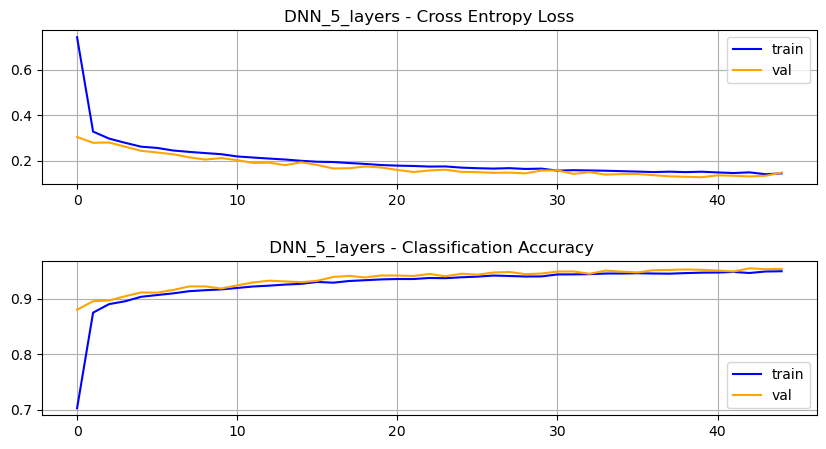

In [16]:
# learning curves
summarize_diagnostics(history, 'DNN_5_layers')

In [17]:
# save the model to a file
if not os.path.isdir('models/'):
        os.makedirs('models/')
model.save("models/model.h5")

## Testing the model
Since the model now is trained and the weights are optimal, let's test it using the testing set we created earlier:

In [18]:
# evaluating the model using the testing set
print(f"Evaluating the model using {len(data['X_test'])} samples...")
loss, accuracy = model.evaluate(data["X_test"], data["y_test"], verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.1290
Accuracy: 95.55%


Excellent, we've reached 95.55% accuracy on samples that the model has never seen before. **Some other combination of feature extraction techniques have been tried but this one is the most effective**.

## Testing the Model with your own Voice
In order to test if the model is really working well, I've made a script that records your voice until you stop speaking (you can talk in any language, though) and save it to a file, then extract features from that audio and feed it to the model to retrieve results.

** To test the model with you own voice, juss